In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR
from torch.utils.data import Dataset, DataLoader

from torchvision.datasets import CIFAR10
from torchvision.models import resnet18, resnet34, resnet50
import torchvision.transforms as transforms
from torchsummary import summary

import numpy as np
import time
import pickle
import pandas as pd
import re
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from medmnist import PathMNIST

from eqCLR.eq_resnet import EqResNet18, Mixed_EqResnet18
from eqCLR.test_resnet import Wide_ResNet
from evaluation import model_eval, dataset_to_X_y, lin_eval_rep

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2026-02-23 12:00:52.909366: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-23 12:00:52.972153: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-23 12:01:27.397370: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
class RandomRightAngleRotation:
    """Randomly rotate PIL image by 90, 180, or 270 degrees."""
    def __call__(self, x):
        angle = int(torch.randint(1, 4, ()).item()) * 90
        return x.rotate(angle)

In [4]:
# default resnet18
with open('results/model_eval/5561-resnet18_resize_33_default_eval.pkl', 'rb') as f:
    eval_resnet18 = pickle.load(f)

with open('results/model_details/5561-resnet18_resize_33_default_details.pkl', 'rb') as f:
    details_resnet18 = pickle.load(f)

# default resnet34
with open('results/model_eval/9399-resnet34_resize_33_default_eval.pkl', 'rb') as f:
    eval_resnet34 = pickle.load(f)

with open('results/model_details/9399-resnet34_resize_33_default_details.pkl', 'rb') as f:
    details_resnet34 = pickle.load(f)

# default resnet50
with open('results/model_eval/6677-resnet50_resize_33_default_eval.pkl', 'rb') as f:
    eval_resnet50 = pickle.load(f)

with open('results/model_details/6677-resnet50_resize_33_default_details.pkl', 'rb') as f:
    details_resnet50 = pickle.load(f)


In [5]:
# eqResnet

# N=1
with open('results/model_eval/3936-path_mnist-eqCLR_N1_resize33_eval.pkl', 'rb') as f:
    eval_eqresnet_n1 = pickle.load(f)

with open('results/model_details/3936-path_mnist-eqCLR_N1_resize33_details.pkl', 'rb') as f:
    details_eqresnet_n1 = pickle.load(f)

# N=2
with open('results/model_eval/4306-path_mnist-eqCLR_N2_resize33_eval.pkl', 'rb') as f:
    eval_eqresnet_n2 = pickle.load(f)

with open('results/model_details/4306-path_mnist-eqCLR_N2_resize33_details.pkl', 'rb') as f:
    details_eqresnet_n2 = pickle.load(f)

# N=4
with open('results/model_eval/0765-path_mnist-eqCLR_N4_resize33_eval.pkl', 'rb') as f:
    eval_eqresnet_n4 = pickle.load(f)

with open('results/model_details/0765-path_mnist-eqCLR_N4_resize33_details.pkl', 'rb') as f:
    details_eqresnet_n4 = pickle.load(f)

# N=6
with open('results/model_eval/8827-path_mnist-eqCLR_N6_resize33_eval.pkl', 'rb') as f:
    eval_eqresnet_n6 = pickle.load(f)

with open('results/model_details/8827-path_mnist-eqCLR_N6_resize33_details.pkl', 'rb') as f:
    details_eqresnet_n6 = pickle.load(f)

# N=8
with open('results/model_eval/5241-path_mnist-eqCLR_N8_resize33_default_eval.pkl', 'rb') as f:
    eval_eqresnet_n8 = pickle.load(f)

with open('results/model_details/5241-path_mnist-eqCLR_N8_resize33_default_details.pkl', 'rb') as f:
    details_eqresnet_n8 = pickle.load(f)

In [13]:
details_eqresnet_n8.keys()

dict_keys(['Filename', 'Model structure', 'N_EPOCHS', 'BATCH_SIZE', 'BASE_LR', 'WEIGHT_DECAY', 'MOMENTUM', 'CROP_LOW_SCALE', 'GRAYSCALE_PROB', 'PROJECTOR_HIDDEN_SIZE', 'PROJECTOR_OUTPUT_SIZE', 'Training augmentations', 'Training time', 'Training time per epoch', 'KNN during training', 'IMG_RESIZE'])

In [6]:
knn_acc = {'ResNet18': eval_resnet18['euclidean'][10],
           'Resnet34': eval_resnet34['euclidean'][10],
           'Resnet50': eval_resnet50['euclidean'][10],
           'eqResNet18 \n(N=1)': eval_eqresnet_n1['euclidean'][10],
           'eqResNet18 \n(N=2)': eval_eqresnet_n2['euclidean'][10],
           'eqResNet18 \n(N=4)': eval_eqresnet_n4['euclidean'][10],
           'eqResNet18 \n(N=6)': eval_eqresnet_n6['euclidean'][10],
           'eqResNet18 \n(N=8)': eval_eqresnet_n8['euclidean'][10]
           }

time_train = {'ResNet18': details_resnet18['Training time w/o evaluation'] / details_resnet18['N_EPOCHS'],
              'Resnet34': details_resnet34['Training time w/o evaluation'] / details_resnet34['N_EPOCHS'],
                'Resnet50': details_resnet50['Training time w/o evaluation'] / details_resnet50['N_EPOCHS'],
              'eqResNet18 \n(N=1)': details_eqresnet_n1['Training time w/o evaluation'] / details_eqresnet_n1['N_EPOCHS'],
              'eqResNet18 \n(N=2)': details_eqresnet_n2['Training time w/o evaluation'] / details_eqresnet_n2['N_EPOCHS'],
              'eqResNet18 \n(N=4)': details_eqresnet_n4['Training time w/o evaluation'] / details_eqresnet_n4['N_EPOCHS'],
              'eqResNet18 \n(N=6)': details_eqresnet_n6['Training time w/o evaluation'] / details_eqresnet_n6['N_EPOCHS'],
              'eqResNet18 \n(N=8)': details_eqresnet_n8['Training time w/o evaluation'] / details_eqresnet_n8['N_EPOCHS']
              }

In [7]:
knn_acc_res = {'ResNet18': eval_resnet18['euclidean'][10],
           'Resnet34': eval_resnet34['euclidean'][10],
           'Resnet50': eval_resnet50['euclidean'][10],
           }

time_train_res = {'ResNet18': details_resnet18['Training time w/o evaluation'] / details_resnet18['N_EPOCHS'],
              'Resnet34': details_resnet34['Training time w/o evaluation'] / details_resnet34['N_EPOCHS'],
                'Resnet50': details_resnet50['Training time w/o evaluation'] / details_resnet50['N_EPOCHS'],
              }

knn_acc_ic = {
           'N=1': eval_eqresnet_n1['euclidean'][10],
           'N=2': eval_eqresnet_n2['euclidean'][10],
           'N=4': eval_eqresnet_n4['euclidean'][10],
           'N=6': eval_eqresnet_n6['euclidean'][10],
           'N=8': eval_eqresnet_n8['euclidean'][10]
           }

time_train_ic = {
              'N=1': details_eqresnet_n1['Training time w/o evaluation'] / details_eqresnet_n1['N_EPOCHS'],
              'N=2': details_eqresnet_n2['Training time w/o evaluation'] / details_eqresnet_n2['N_EPOCHS'],
              'N=4': details_eqresnet_n4['Training time w/o evaluation'] / details_eqresnet_n4['N_EPOCHS'],
              'N=6': details_eqresnet_n6['Training time w/o evaluation'] / details_eqresnet_n6['N_EPOCHS'],
              'N=8': details_eqresnet_n8['Training time w/o evaluation'] / details_eqresnet_n8['N_EPOCHS']
              }

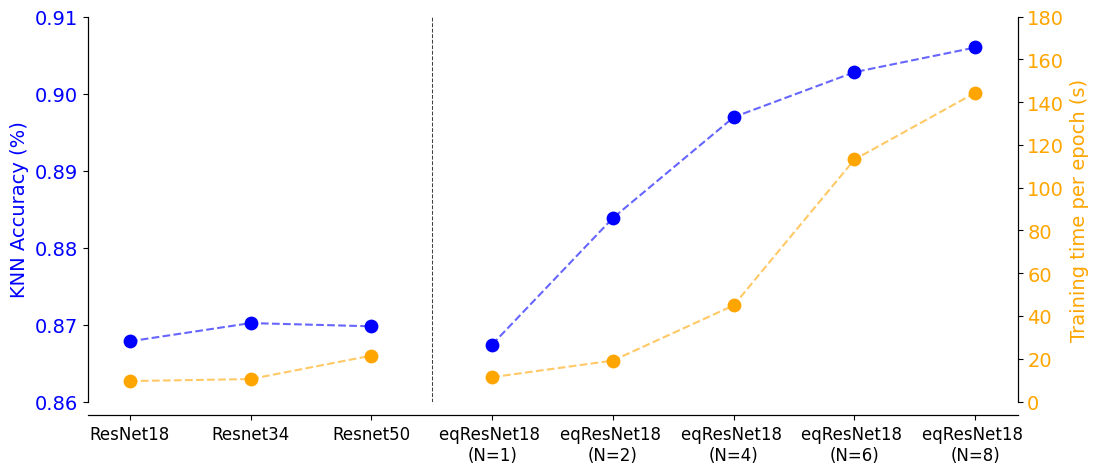

In [8]:
labels = list(knn_acc.keys())
knn_values = list(knn_acc.values())

x = np.arange(len(labels))  # numeric positions

fig, ax = plt.subplots(figsize=(12, 5))
size = 14

# scatter points
ax.scatter(x, knn_values, s=80, zorder=3, color='blue', label='KNN Accuracy')
ax.plot(x[:3], knn_values[:3], linestyle='--', alpha=0.6, zorder=2, color='blue')
ax.plot(x[3:], knn_values[3:], linestyle='--', alpha=0.6, zorder=2, color='blue')

ax.set_xticks(x)
ax.set_xticklabels(labels, ha='center', fontsize=size)
ax.tick_params(axis='x', labelsize=size-2)

# baseline_label = 'ResNet18'
# split_x = labels.index(baseline_label) + 0.5
# ax.axvline(split_x, linestyle='--', linewidth=0.75, alpha=0.75, color='black', zorder=1)

ax.set_ylabel('KNN Accuracy (%)', color='blue', fontsize=size)
ax.tick_params(axis='y', labelcolor='blue', labelsize=size)
ax.set_ylim(0.86, 0.91)

# time axis
ax2 = ax.twinx()
time_values = [time_train[label] for label in labels]
ax2.scatter(x, time_values, color='orange', marker='o', label='Training time per epoch', zorder=3, s=80, clip_on=False)

ax2.plot(x[:3], time_values[:3], linestyle='--', color='orange', alpha=0.6, zorder=2)
ax2.plot(x[3:], time_values[3:], linestyle='--', color='orange', alpha=0.6, zorder=2)

# vertical line to separate baselines from eqResNets
ax.axvline(2.5, linestyle='--', linewidth=0.75, alpha=0.75, color='black', zorder=1)

ax2.set_ylabel('Training time per epoch (s)', color='orange', fontsize=size)
ax2.tick_params(axis='y', labelcolor='orange', labelsize=size)
ax2.set_ylim(0, 180)

ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
# ax2.set_xticklabels(labels, ha='center', fontsize=size)

ax.spines['bottom'].set_position(('outward', 10))
ax2.spines['bottom'].set_position(('outward', 10))

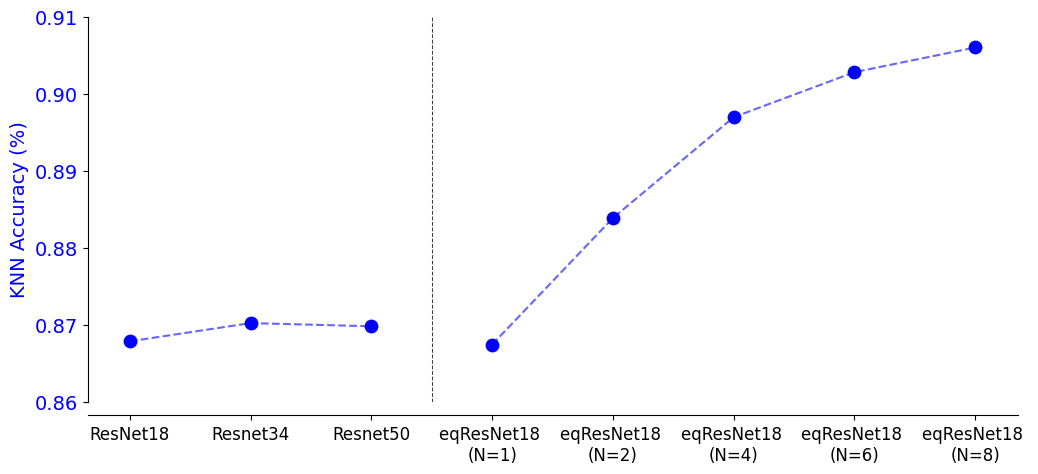

In [11]:
labels = list(knn_acc.keys())
knn_values = list(knn_acc.values())

x = np.arange(len(labels))  # numeric positions

fig, ax = plt.subplots(figsize=(12, 5))
size = 14

# scatter points
ax.scatter(x, knn_values, s=80, zorder=3, color='blue', label='KNN Accuracy')
ax.plot(x[:3], knn_values[:3], linestyle='--', alpha=0.6, zorder=2, color='blue')
ax.plot(x[3:], knn_values[3:], linestyle='--', alpha=0.6, zorder=2, color='blue')

ax.set_xticks(x)
ax.set_xticklabels(labels, ha='center', fontsize=size)
ax.tick_params(axis='x', labelsize=size-2)

baseline_label = 'Resnet50'
split_x = labels.index(baseline_label) + 0.5
ax.axvline(split_x, linestyle='--', linewidth=0.75, alpha=0.75, color='black', zorder=1)

ax.set_ylabel('KNN Accuracy (%)', color='blue', fontsize=size)
ax.tick_params(axis='y', labelcolor='blue', labelsize=size)
ax.set_ylim(0.86, 0.91)

# time axis
# ax2 = ax.twinx()
# time_values = [time_train[label] for label in labels]
# ax2.scatter(x, time_values, color='orange', marker='o', label='Training time per epoch', zorder=3, s=80, clip_on=False)

# ax2.plot(x[:3], time_values[:3], linestyle='--', color='orange', alpha=0.6, zorder=2)
# ax2.plot(x[3:], time_values[3:], linestyle='--', color='orange', alpha=0.6, zorder=2)

# # vertical line to separate baselines from eqResNets
# ax.axvline(2.5, linestyle='--', linewidth=0.75, alpha=0.75, color='black', zorder=1)

# ax2.set_ylabel('Training time per epoch (s)', color='orange', fontsize=size)
# ax2.tick_params(axis='y', labelcolor='orange', labelsize=size)
# ax2.set_ylim(0, 180)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax2.spines['top'].set_visible(False)
# # ax2.set_xticklabels(labels, ha='center', fontsize=size)

ax.spines['bottom'].set_position(('outward', 10))
# ax2.spines['bottom'].set_position(('outward', 10))

# Constant number of params

In [21]:
# eqResnet

# N=1
with open('results/model_eval/1010-path_mnist-eqCLR_resnet18_N1_keepdim_params_resize33_eval.pkl', 'rb') as f:
    eval_eqresnet_cp_n1 = pickle.load(f)

with open('results/model_details/1010-path_mnist-eqCLR_resnet18_N1_keepdim_params_resize33_details.pkl', 'rb') as f:
    details_eqresnet_cp_n1 = pickle.load(f)

# N=2
with open('results/model_eval/1010-path_mnist-eqCLR_resnet18_N2_keepdim_params_resize33_eval.pkl', 'rb') as f:
    eval_eqresnet_cp_n2 = pickle.load(f)

with open('results/model_details/1010-path_mnist-eqCLR_resnet18_N2_keepdim_params_resize33_details.pkl', 'rb') as f:
    details_eqresnet_cp_n2 = pickle.load(f)

# N=3
with open('results/model_eval/1010-path_mnist-eqCLR_resnet18_N3_keepdim_params_resize33_eval.pkl', 'rb') as f:
    eval_eqresnet_cp_n3 = pickle.load(f)

with open('results/model_details/1010-path_mnist-eqCLR_resnet18_N3_keepdim_params_resize33_details.pkl', 'rb') as f:
    details_eqresnet_cp_n3 = pickle.load(f)

# N=4
with open('results/model_eval/1010-path_mnist-eqCLR_resnet18_N4_keepdim_params_resize33_eval.pkl', 'rb') as f:
    eval_eqresnet_cp_n4 = pickle.load(f)

with open('results/model_details/1010-path_mnist-eqCLR_resnet18_N4_keepdim_params_resize33_details.pkl', 'rb') as f:
    details_eqresnet_cp_n4 = pickle.load(f)

# N=5
with open('results/model_eval/1010-path_mnist-eqCLR_resnet18_N5_keepdim_params_resize33_eval.pkl', 'rb') as f:
        eval_eqresnet_cp_n5 = pickle.load(f)

with open('results/model_details/1010-path_mnist-eqCLR_resnet18_N5_keepdim_params_resize33_details.pkl', 'rb') as f:
    details_eqresnet_cp_n5 = pickle.load(f)

# N=6
with open('results/model_eval/1010-path_mnist-eqCLR_resnet18_N6_keepdim_params_resize33_eval.pkl', 'rb') as f:
    eval_eqresnet_cp_n6 = pickle.load(f)

with open('results/model_details/1010-path_mnist-eqCLR_resnet18_N6_keepdim_params_resize33_details.pkl', 'rb') as f:
    details_eqresnet_cp_n6 = pickle.load(f)

# N=7
with open('results/model_eval/1010-path_mnist-eqCLR_resnet18_N7_keepdim_params_resize33_eval.pkl', 'rb') as f:
    eval_eqresnet_cp_n7 = pickle.load(f)

with open('results/model_details/1010-path_mnist-eqCLR_resnet18_N7_keepdim_params_resize33_details.pkl', 'rb') as f:
    details_eqresnet_cp_n7 = pickle.load(f)

# N=8
with open('results/model_eval/1010-path_mnist-eqCLR_resnet18_N8_keepdim_params_resize33_eval.pkl', 'rb') as f:
    eval_eqresnet_cp_n8 = pickle.load(f)

with open('results/model_details/1010-path_mnist-eqCLR_resnet18_N8_keepdim_params_resize33_details.pkl', 'rb') as f:
    details_eqresnet_cp_n8 = pickle.load(f)

In [22]:
knn_acc = {'ResNet18': eval_resnet18['euclidean'][10],
           'Resnet34': eval_resnet34['euclidean'][10],
           'Resnet50': eval_resnet50['euclidean'][10],
           'N=1': eval_eqresnet_cp_n1['euclidean'][10],
           'N=2': eval_eqresnet_cp_n2['euclidean'][10],
           'N=3': eval_eqresnet_cp_n3['euclidean'][10],
           'N=4': eval_eqresnet_cp_n4['euclidean'][10],
           'N=5': eval_eqresnet_cp_n5['euclidean'][10],
           'N=6': eval_eqresnet_cp_n6['euclidean'][10],
           'N=7': eval_eqresnet_cp_n7['euclidean'][10],
           'N=8': eval_eqresnet_cp_n8['euclidean'][10]
           }

time_train = {'ResNet18': details_resnet18['Training time w/o evaluation'] / details_resnet18['N_EPOCHS'],
              'Resnet34': details_resnet34['Training time w/o evaluation'] / details_resnet34['N_EPOCHS'],
                'Resnet50': details_resnet50['Training time w/o evaluation'] / details_resnet50['N_EPOCHS'],
              'N=1': details_eqresnet_cp_n1['Training time w/o evaluation'] / details_eqresnet_cp_n1['N_EPOCHS'],
              'N=2': details_eqresnet_cp_n2['Training time w/o evaluation'] / details_eqresnet_cp_n2['N_EPOCHS'],
              'N=3': details_eqresnet_cp_n3['Training time w/o evaluation'] / details_eqresnet_cp_n3['N_EPOCHS'],
              'N=4': details_eqresnet_cp_n4['Training time w/o evaluation'] / details_eqresnet_cp_n4['N_EPOCHS'],
              'N=5': details_eqresnet_cp_n5['Training time w/o evaluation'] / details_eqresnet_cp_n5['N_EPOCHS'],
              'N=6': details_eqresnet_cp_n6['Training time w/o evaluation'] / details_eqresnet_cp_n6['N_EPOCHS'],
              'N=7': details_eqresnet_cp_n7['Training time w/o evaluation'] / details_eqresnet_cp_n7['N_EPOCHS'],
              'N=8': details_eqresnet_cp_n8['Training time w/o evaluation'] / details_eqresnet_cp_n8['N_EPOCHS']
              }

In [26]:
knn_acc_cp = {
           'N=1': eval_eqresnet_cp_n1['euclidean'][10],
           'N=2': eval_eqresnet_cp_n2['euclidean'][10],
           'N=3': eval_eqresnet_cp_n3['euclidean'][10],
           'N=4': eval_eqresnet_cp_n4['euclidean'][10],
           'N=5': eval_eqresnet_cp_n5['euclidean'][10],
           'N=6': eval_eqresnet_cp_n6['euclidean'][10],
           'N=7': eval_eqresnet_cp_n7['euclidean'][10],
           'N=8': eval_eqresnet_cp_n8['euclidean'][10]
           }

time_train_cp = {
              'N=1': details_eqresnet_cp_n1['Training time w/o evaluation'] / details_eqresnet_cp_n1['N_EPOCHS'],
              'N=2': details_eqresnet_cp_n2['Training time w/o evaluation'] / details_eqresnet_cp_n2['N_EPOCHS'],
              'N=3': details_eqresnet_cp_n3['Training time w/o evaluation'] / details_eqresnet_cp_n3['N_EPOCHS'],
              'N=4': details_eqresnet_cp_n4['Training time w/o evaluation'] / details_eqresnet_cp_n4['N_EPOCHS'],
              'N=5': details_eqresnet_cp_n5['Training time w/o evaluation'] / details_eqresnet_cp_n5['N_EPOCHS'],
              'N=6': details_eqresnet_cp_n6['Training time w/o evaluation'] / details_eqresnet_cp_n6['N_EPOCHS'],
              'N=7': details_eqresnet_cp_n7['Training time w/o evaluation'] / details_eqresnet_cp_n7['N_EPOCHS'],
              'N=8': details_eqresnet_cp_n8['Training time w/o evaluation'] / details_eqresnet_cp_n8['N_EPOCHS']
              }

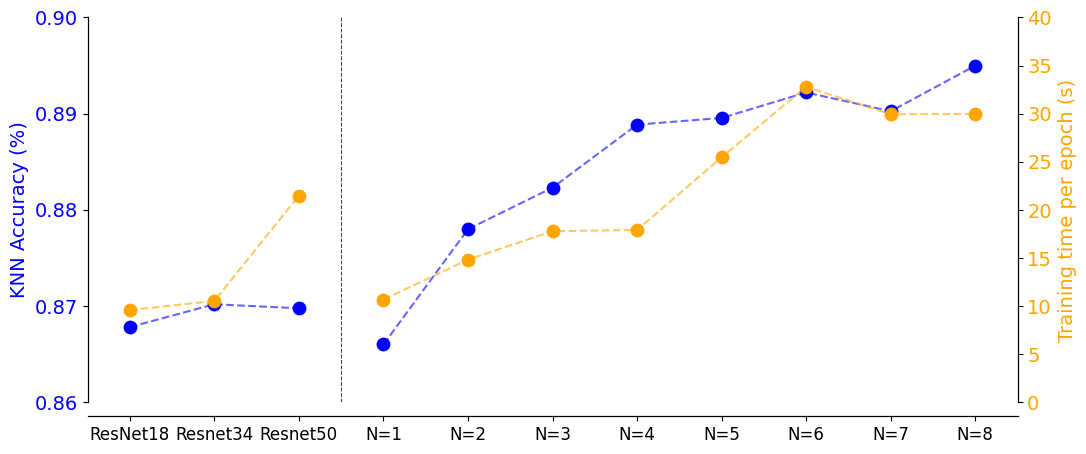

In [25]:
labels = list(knn_acc.keys())
knn_values = list(knn_acc.values())

x = np.arange(len(labels))  # numeric positions

fig, ax = plt.subplots(figsize=(12, 5))
size = 14

# scatter points
ax.scatter(x, knn_values, s=80, zorder=3, color='blue', label='KNN Accuracy')
ax.plot(x[:3], knn_values[:3], linestyle='--', alpha=0.6, zorder=2, color='blue')
ax.plot(x[3:], knn_values[3:], linestyle='--', alpha=0.6, zorder=2, color='blue')

ax.set_xticks(x)
ax.set_xticklabels(labels, ha='center', fontsize=size)
ax.tick_params(axis='x', labelsize=size-2)

# baseline_label = 'ResNet18'
# split_x = labels.index(baseline_label) + 0.5
# ax.axvline(split_x, linestyle='--', linewidth=0.75, alpha=0.75, color='black', zorder=1)

ax.set_ylabel('KNN Accuracy (%)', color='blue', fontsize=size)
ax.tick_params(axis='y', labelcolor='blue', labelsize=size)
ax.set_ylim(0.86, 0.9)
ax.set_yticks([0.86, 0.87, 0.88, 0.89, 0.9])

# time axis
ax2 = ax.twinx()
time_values = [time_train[label] for label in labels]
ax2.scatter(x, time_values, color='orange', marker='o', label='Training time per epoch', zorder=3, s=80, clip_on=False)

ax2.plot(x[:3], time_values[:3], linestyle='--', color='orange', alpha=0.6, zorder=2)
ax2.plot(x[3:], time_values[3:], linestyle='--', color='orange', alpha=0.6, zorder=2)

# vertical line to separate baselines from eqResNets
ax.axvline(2.5, linestyle='--', linewidth=0.75, alpha=0.75, color='black', zorder=1)

ax2.set_ylabel('Training time per epoch (s)', color='orange', fontsize=size)
ax2.tick_params(axis='y', labelcolor='orange', labelsize=size)
ax2.set_ylim(0, 40)
#ax2.set_yticks([0, 25, 50, 75, 100, 125, 150])

ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
# ax2.set_xticklabels(labels, ha='center', fontsize=size)

ax.spines['bottom'].set_position(('outward', 10))
ax2.spines['bottom'].set_position(('outward', 10))

# Constant number of total channels

In [14]:
# eqResnet evals size adjusted

# N=1
with open('results/model_eval/0153-path_mnist-eqCLR_N1_keepdim_resize33_eval.pkl', 'rb') as f:
    eval_eqresnet_n1a = pickle.load(f)

# N=2
with open('results/model_eval/8849-path_mnist-eqCLR_N2_keepdim_resize33_eval.pkl', 'rb') as f:
    eval_eqresnet_n2a = pickle.load(f)

# N=3
with open('results/model_eval/0970-path_mnist-eqCLR_N3_keepdim_resize33_eval.pkl', 'rb') as f:
    eval_eqresnet_n3a = pickle.load(f)
# N=4
with open('results/model_eval/7117-path_mnist-eqCLR_N4_keepdim_resize33_eval.pkl', 'rb') as f:
    eval_eqresnet_n4a = pickle.load(f)

# N=5
with open('results/model_eval/3710-path_mnist-eqCLR_N5_keepdim_resize33_eval.pkl', 'rb') as f:
    eval_eqresnet_n5a = pickle.load(f)
# N=6
with open('results/model_eval/4903-path_mnist-eqCLR_N6_keepdim_resize33_eval.pkl', 'rb') as f:
    eval_eqresnet_n6a = pickle.load(f)

# N=7
with open('results/model_eval/7876-path_mnist-eqCLR_N7_keepdim_resize33_eval.pkl', 'rb') as f:
    eval_eqresnet_n7a = pickle.load(f)

# N=8
with open('results/model_eval/6103-path_mnist-eqCLR_N8_keepdim_resize33_eval.pkl', 'rb') as f:
    eval_eqresnet_n8a = pickle.load(f)
# N=9
with open('results/model_eval/2256-path_mnist-eqCLR_N9_keepdim_resize33_eval.pkl', 'rb') as f:
    eval_eqresnet_n9a = pickle.load(f)

# N=10
with open('results/model_eval/3135-path_mnist-eqCLR_N10_keepdim_resize33_eval.pkl', 'rb') as f:
    eval_eqresnet_n10a = pickle.load(f)
# N=11
with open('results/model_eval/7268-path_mnist-eqCLR_N11_keepdim_resize33_eval.pkl', 'rb') as f:
    eval_eqresnet_n11a = pickle.load(f)

# N=12
with open('results/model_eval/0182-path_mnist-eqCLR_N12_keepdim_resize33_eval.pkl', 'rb') as f:
    eval_eqresnet_n12a = pickle.load(f)

In [15]:
# eqResnet model info

# N=1
with open('results/model_details/0153-path_mnist-eqCLR_N1_keepdim_resize33_details.pkl', 'rb') as f:
    details_eqresnet_n1a = pickle.load(f)

# N=2
with open('results/model_details/8849-path_mnist-eqCLR_N2_keepdim_resize33_details.pkl', 'rb') as f:
    details_eqresnet_n2a = pickle.load(f)

# N=3
with open('results/model_details/0970-path_mnist-eqCLR_N3_keepdim_resize33_details.pkl', 'rb') as f:
    details_eqresnet_n3a = pickle.load(f)
# N=4
with open('results/model_details/7117-path_mnist-eqCLR_N4_keepdim_resize33_details.pkl', 'rb') as f:
    details_eqresnet_n4a = pickle.load(f)

# N=5
with open('results/model_details/3710-path_mnist-eqCLR_N5_keepdim_resize33_details.pkl', 'rb') as f:
    details_eqresnet_n5a = pickle.load(f)
# N=6
with open('results/model_details/4903-path_mnist-eqCLR_N6_keepdim_resize33_details.pkl', 'rb') as f:
    details_eqresnet_n6a = pickle.load(f)

# N=7
with open('results/model_details/7876-path_mnist-eqCLR_N7_keepdim_resize33_details.pkl', 'rb') as f:
    details_eqresnet_n7a = pickle.load(f)
# N=8
with open('results/model_details/6103-path_mnist-eqCLR_N8_keepdim_resize33_details.pkl', 'rb') as f:
    details_eqresnet_n8a = pickle.load(f)
# N=9
with open('results/model_details/2256-path_mnist-eqCLR_N9_keepdim_resize33_details.pkl', 'rb') as f:
    details_eqresnet_n9a = pickle.load(f)

# N=10
with open('results/model_details/3135-path_mnist-eqCLR_N10_keepdim_resize33_details.pkl', 'rb') as f:
    details_eqresnet_n10a = pickle.load(f)
# N=11
with open('results/model_details/7268-path_mnist-eqCLR_N11_keepdim_resize33_details.pkl', 'rb') as f:
    details_eqresnet_n11a = pickle.load(f)

# N=12
with open('results/model_details/0182-path_mnist-eqCLR_N12_keepdim_resize33_details.pkl', 'rb') as f:
    details_eqresnet_n12a = pickle.load(f)

In [16]:
models_eval = {
    'eqResnet18_N1': eval_eqresnet_n1a,
    'eqResnet18_N2': eval_eqresnet_n2a,
    'eqResnet18_N3': eval_eqresnet_n3a,
    'eqResnet18_N4': eval_eqresnet_n4a,
    'eqResnet18_N5': eval_eqresnet_n5a,
    'eqResnet18_N6': eval_eqresnet_n6a,
    'eqResnet18_N7': eval_eqresnet_n7a,
    'eqResnet18_N8': eval_eqresnet_n8a,
    'eqResnet18_N9': eval_eqresnet_n9a,
    'eqResnet18_N10': eval_eqresnet_n10a,
    'eqResnet18_N11': eval_eqresnet_n11a,
    'eqResnet18_N12': eval_eqresnet_n12a,
    'Resnet18': eval_resnet18
}

eval_dict_all = {}

for model in models_eval:
    eval_dict_all[model] = {}
    eval_dict = models_eval[model]

    for k in [1, 5, 10]:
        eval_dict_all[model][f'KNN (k={k})'] = eval_dict['euclidean'][k]

    for key in eval_dict:
        if key != "cosine" and key != "euclidean" and key != 'linear_accuracy':
            eval_dict_all[model][key] = eval_dict[key]
    

evals_df = pd.DataFrame(eval_dict_all).T

display(evals_df)

,KNN (k=1),KNN (k=5),KNN (k=10),logistic_regression,linear_accuracy_rep,linear_accuracy_aug
eqResnet18_N1,0.838997,0.860167,0.865738,0.874652,0.872284,0.870613
eqResnet18_N2,0.843036,0.868384,0.873816,0.876323,0.876880,NaN
eqResnet18_N3,0.845404,0.865738,0.873538,0.886072,0.885376,NaN
eqResnet18_N4,0.850696,0.873816,0.877019,0.891226,0.889276,0.888301
eqResnet18_N5,0.841504,0.870334,0.876184,0.885933,0.884958,0.881755
eqResnet18_N6,0.847354,0.874373,0.879944,0.887047,0.888022,NaN
eqResnet18_N7,0.843454,0.875348,0.879526,0.886212,0.886490,0.889972
eqResnet18_N8,0.844708,0.869081,0.875070,0.885655,0.885515,NaN
eqResnet18_N9,0.838579,0.869220,0.878691,0.891365,0.890390,0.875209
eqResnet18_N10,0.842201,0.863370,0.866992,0.886212,0.888440,NaN


In [17]:
knn_acc = {'ResNet18': eval_resnet18['euclidean'][10],
            '1': eval_eqresnet_n1a['euclidean'][10],
            '2': eval_eqresnet_n2a['euclidean'][10],
            '3': eval_eqresnet_n3a['euclidean'][10],
            '4': eval_eqresnet_n4a['euclidean'][10],
            '5': eval_eqresnet_n5a['euclidean'][10],
            '6': eval_eqresnet_n6a['euclidean'][10],
            '7': eval_eqresnet_n7a['euclidean'][10],
            '8': eval_eqresnet_n8a['euclidean'][10],
            '9': eval_eqresnet_n9a['euclidean'][10],
            '10': eval_eqresnet_n10a['euclidean'][10],
            '11': eval_eqresnet_n11a['euclidean'][10],
            '12': eval_eqresnet_n12a['euclidean'][10]
            }

time_train = {'ResNet18': details_resnet18['Training time w/o evaluation'] / details_resnet18['N_EPOCHS'],
              '1': details_eqresnet_n1a['Training time w/o evaluation'] / details_eqresnet_n1a['N_EPOCHS'],
              '2': details_eqresnet_n2a['Training time w/o evaluation'] / details_eqresnet_n2a['N_EPOCHS'],
              '3': details_eqresnet_n3a['Training time w/o evaluation'] / details_eqresnet_n3a['N_EPOCHS'],
              '4': details_eqresnet_n4a['Training time w/o evaluation'] / details_eqresnet_n4a['N_EPOCHS'],
              '5': details_eqresnet_n5a['Training time w/o evaluation'] / details_eqresnet_n5a['N_EPOCHS'],
              '6': details_eqresnet_n6a['Training time w/o evaluation'] / details_eqresnet_n6a['N_EPOCHS'],
              '7': details_eqresnet_n7a['Training time w/o evaluation'] / details_eqresnet_n7a['N_EPOCHS'],
              '8': details_eqresnet_n8a['Training time w/o evaluation'] / details_eqresnet_n8a['N_EPOCHS'],
              '9': details_eqresnet_n9a['Training time w/o evaluation'] / details_eqresnet_n9a['N_EPOCHS'],
              '10': details_eqresnet_n10a['Training time w/o evaluation'] / details_eqresnet_n10a['N_EPOCHS'],
              '11': details_eqresnet_n11a['Training time w/o evaluation'] / details_eqresnet_n11a['N_EPOCHS'],
              '12': details_eqresnet_n12a['Training time w/o evaluation'] / details_eqresnet_n12a['N_EPOCHS']
              }

In [18]:
knn_acc_cc = {
            'N=1': eval_eqresnet_n1a['euclidean'][10],
            'N=2': eval_eqresnet_n2a['euclidean'][10],
            'N=3': eval_eqresnet_n3a['euclidean'][10],
            'N=4': eval_eqresnet_n4a['euclidean'][10],
            'N=5': eval_eqresnet_n5a['euclidean'][10],
            'N=6': eval_eqresnet_n6a['euclidean'][10],
            'N=7': eval_eqresnet_n7a['euclidean'][10],
            'N=8': eval_eqresnet_n8a['euclidean'][10],
            'N=9': eval_eqresnet_n9a['euclidean'][10],
            'N=10': eval_eqresnet_n10a['euclidean'][10],
            'N=11': eval_eqresnet_n11a['euclidean'][10],
            'N=12': eval_eqresnet_n12a['euclidean'][10]
            }

time_train_cc = {
              'N=1': details_eqresnet_n1a['Training time w/o evaluation'] / details_eqresnet_n1a['N_EPOCHS'],
              'N=2': details_eqresnet_n2a['Training time w/o evaluation'] / details_eqresnet_n2a['N_EPOCHS'],
              'N=3': details_eqresnet_n3a['Training time w/o evaluation'] / details_eqresnet_n3a['N_EPOCHS'],
              'N=4': details_eqresnet_n4a['Training time w/o evaluation'] / details_eqresnet_n4a['N_EPOCHS'],
              'N=5': details_eqresnet_n5a['Training time w/o evaluation'] / details_eqresnet_n5a['N_EPOCHS'],
              'N=6': details_eqresnet_n6a['Training time w/o evaluation'] / details_eqresnet_n6a['N_EPOCHS'],
              'N=7': details_eqresnet_n7a['Training time w/o evaluation'] / details_eqresnet_n7a['N_EPOCHS'],
              'N=8': details_eqresnet_n8a['Training time w/o evaluation'] / details_eqresnet_n8a['N_EPOCHS'],
              'N=9': details_eqresnet_n9a['Training time w/o evaluation'] / details_eqresnet_n9a['N_EPOCHS'],
              'N=10': details_eqresnet_n10a['Training time w/o evaluation'] / details_eqresnet_n10a['N_EPOCHS'],
              'N=11': details_eqresnet_n11a['Training time w/o evaluation'] / details_eqresnet_n11a['N_EPOCHS'],
              'N=12': details_eqresnet_n12a['Training time w/o evaluation'] / details_eqresnet_n12a['N_EPOCHS']
              }

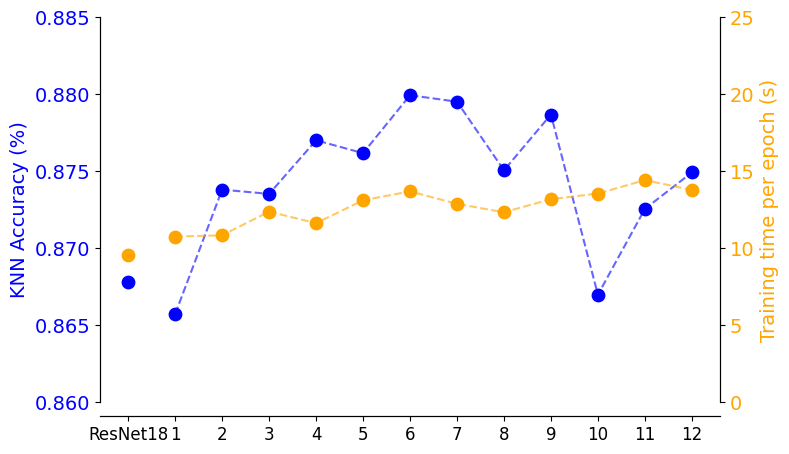

In [19]:
labels = list(knn_acc.keys())
knn_values = list(knn_acc.values())

x = np.arange(len(labels))  # numeric positions

fig, ax = plt.subplots(figsize=(8, 5))
size = 14

# scatter points
ax.scatter(x, knn_values, s=80, zorder=3, color='blue', label='KNN Accuracy')
ax.plot(x[1:], knn_values[1:], linestyle='--', alpha=0.6, zorder=2, color='blue')

ax.set_xticks(x)
ax.set_xticklabels(labels, ha='center', fontsize=size)
ax.tick_params(axis='x', labelsize=size-2)

# baseline_label = 'ResNet18'
# split_x = labels.index(baseline_label) + 0.5
# ax.axvline(split_x, linestyle='--', linewidth=0.75, alpha=0.75, color='black', zorder=1)

ax.set_ylabel('KNN Accuracy (%)', color='blue', fontsize=size)
ax.tick_params(axis='y', labelcolor='blue', labelsize=size)
ax.set_ylim(0.86, 0.885)

# time axis
ax2 = ax.twinx()
time_values = [time_train[label] for label in labels]
ax2.scatter(x, time_values, color='orange', marker='o', label='Training time per epoch', zorder=3, s=80, clip_on=False)
ax2.plot(x[1:], time_values[1:], linestyle='--', color='orange', alpha=0.6, zorder=2)
ax2.set_ylabel('Training time per epoch (s)', color='orange', fontsize=size)
ax2.tick_params(axis='y', labelcolor='orange', labelsize=size)
ax2.set_ylim(0, 25)

ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
# ax2.set_xticklabels(labels, ha='center', fontsize=size)

ax.spines['bottom'].set_position(('outward', 10))
ax2.spines['bottom'].set_position(('outward', 10))

In [25]:
knn_acc = {'ResNet18': eval_resnet18['euclidean'][10],
           'Resnet34': eval_resnet34['euclidean'][10],
           'Resnet50': eval_resnet50['euclidean'][10],
            '1': eval_eqresnet_n1a['euclidean'][10],
            '2': eval_eqresnet_n2a['euclidean'][10],
            '3': eval_eqresnet_n3a['euclidean'][10],
            '4': eval_eqresnet_n4a['euclidean'][10],
            '5': eval_eqresnet_n5a['euclidean'][10],
            '6': eval_eqresnet_n6a['euclidean'][10],
            '7': eval_eqresnet_n7a['euclidean'][10],
            '8': eval_eqresnet_n8a['euclidean'][10],
            '9': eval_eqresnet_n9a['euclidean'][10],
            '10': eval_eqresnet_n10a['euclidean'][10],
            '11': eval_eqresnet_n11a['euclidean'][10],
            '12': eval_eqresnet_n12a['euclidean'][10]
            }

time_train = {'ResNet18': details_resnet18['Training time w/o evaluation'] / details_resnet18['N_EPOCHS'],
                'Resnet34': details_resnet34['Training time w/o evaluation'] / details_resnet34['N_EPOCHS'],
                'Resnet50': details_resnet50['Training time w/o evaluation'] / details_resnet50['N_EPOCHS'],
              '1': details_eqresnet_n1a['Training time w/o evaluation'] / details_eqresnet_n1a['N_EPOCHS'],
              '2': details_eqresnet_n2a['Training time w/o evaluation'] / details_eqresnet_n2a['N_EPOCHS'],
              '3': details_eqresnet_n3a['Training time w/o evaluation'] / details_eqresnet_n3a['N_EPOCHS'],
              '4': details_eqresnet_n4a['Training time w/o evaluation'] / details_eqresnet_n4a['N_EPOCHS'],
              '5': details_eqresnet_n5a['Training time w/o evaluation'] / details_eqresnet_n5a['N_EPOCHS'],
              '6': details_eqresnet_n6a['Training time w/o evaluation'] / details_eqresnet_n6a['N_EPOCHS'],
              '7': details_eqresnet_n7a['Training time w/o evaluation'] / details_eqresnet_n7a['N_EPOCHS'],
              '8': details_eqresnet_n8a['Training time w/o evaluation'] / details_eqresnet_n8a['N_EPOCHS'],
              '9': details_eqresnet_n9a['Training time w/o evaluation'] / details_eqresnet_n9a['N_EPOCHS'],
              '10': details_eqresnet_n10a['Training time w/o evaluation'] / details_eqresnet_n10a['N_EPOCHS'],
              '11': details_eqresnet_n11a['Training time w/o evaluation'] / details_eqresnet_n11a['N_EPOCHS'],
              '12': details_eqresnet_n12a['Training time w/o evaluation'] / details_eqresnet_n12a['N_EPOCHS']
              }

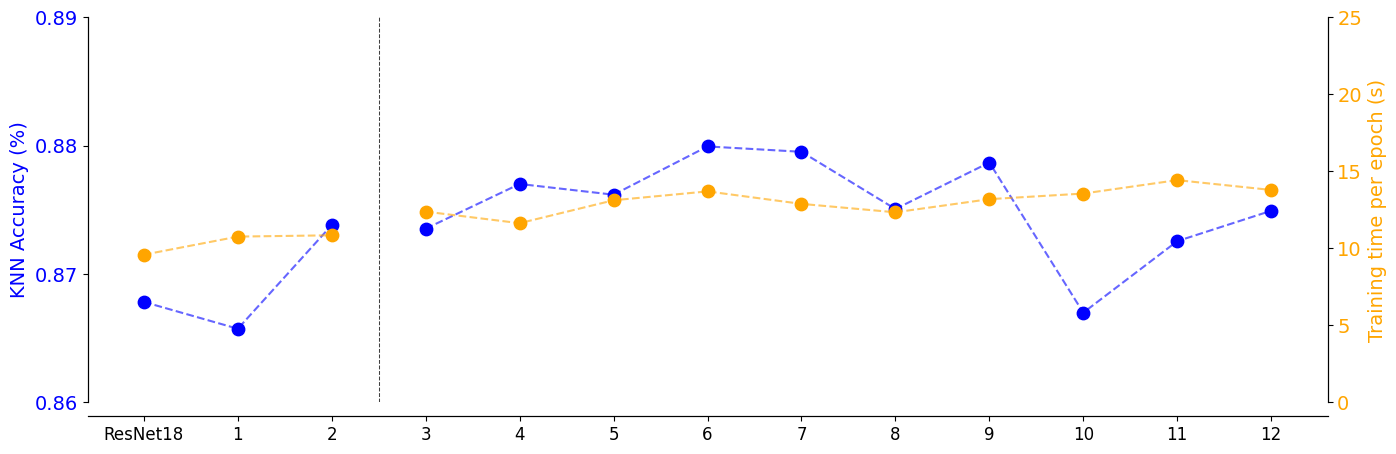

In [20]:
labels = list(knn_acc.keys())
knn_values = list(knn_acc.values())

x = np.arange(len(labels))  # numeric positions

fig, ax = plt.subplots(figsize=(16, 5))
size = 14

# scatter points
ax.scatter(x, knn_values, s=80, zorder=3, color='blue', label='KNN Accuracy')
ax.plot(x[:3], knn_values[:3], linestyle='--', alpha=0.6, zorder=2, color='blue')
ax.plot(x[3:], knn_values[3:], linestyle='--', alpha=0.6, zorder=2, color='blue')

ax.set_xticks(x)
ax.set_xticklabels(labels, ha='center', fontsize=size)
ax.tick_params(axis='x', labelsize=size-2)

# baseline_label = 'ResNet18'
# split_x = labels.index(baseline_label) + 0.5
# ax.axvline(split_x, linestyle='--', linewidth=0.75, alpha=0.75, color='black', zorder=1)

ax.set_ylabel('KNN Accuracy (%)', color='blue', fontsize=size)
ax.tick_params(axis='y', labelcolor='blue', labelsize=size)
ax.set_ylim(0.86, 0.89)
ax.set_yticks([0.86, 0.87, 0.88, 0.89])

# time axis
ax2 = ax.twinx()
time_values = [time_train[label] for label in labels]
ax2.scatter(x, time_values, color='orange', marker='o', label='Training time per epoch', zorder=3, s=80, clip_on=False)

ax2.plot(x[:3], time_values[:3], linestyle='--', color='orange', alpha=0.6, zorder=2)
ax2.plot(x[3:], time_values[3:], linestyle='--', color='orange', alpha=0.6, zorder=2)

# vertical line to separate baselines from eqResNets
ax.axvline(2.5, linestyle='--', linewidth=0.75, alpha=0.75, color='black', zorder=1)

ax2.set_ylabel('Training time per epoch (s)', color='orange', fontsize=size)
ax2.tick_params(axis='y', labelcolor='orange', labelsize=size)
ax2.set_ylim(0, 25)

ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
# ax2.set_xticklabels(labels, ha='center', fontsize=size)

ax.spines['bottom'].set_position(('outward', 10))
ax2.spines['bottom'].set_position(('outward', 10))

# All equivarinat versions

In [83]:
from matplotlib.lines import Line2D

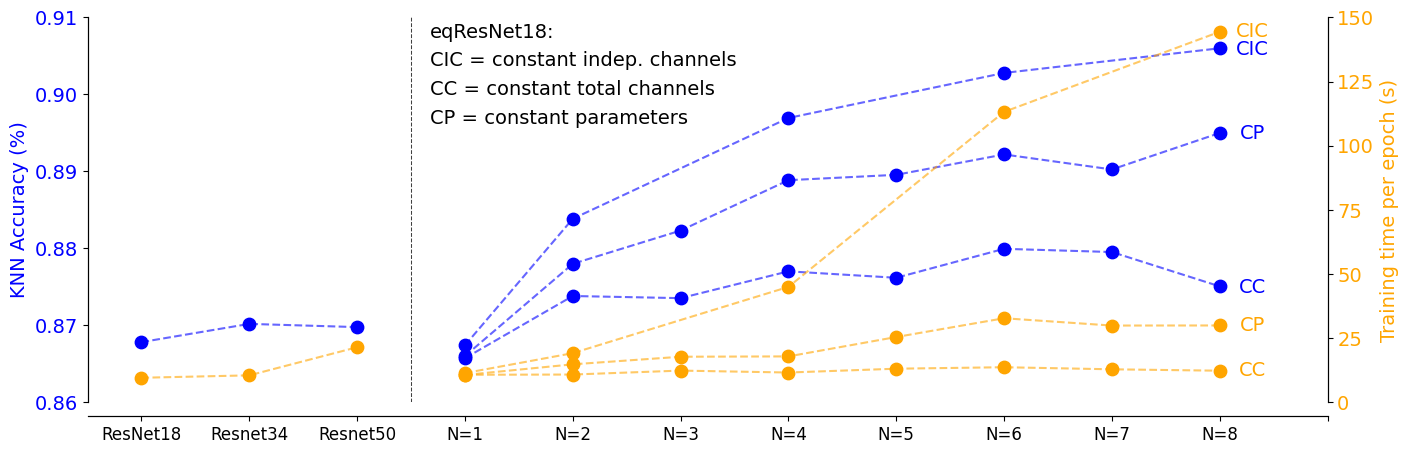

In [107]:
labels = list(knn_acc_res.keys()) + list(knn_acc_cp.keys()) + ['']

x = np.arange(len(labels))  # numeric positions
label_to_x = {label: i for i, label in enumerate(labels)}

fig, ax = plt.subplots(figsize=(16, 5))
size = 14
ax2 = ax.twinx()

# default resnet baselines
knn_values_res = list(knn_acc_res.values())
x_res = [label_to_x[k] for k in knn_acc_res.keys()]
ax.scatter(x_res, knn_values_res, s=80, zorder=3, color='blue', label='KNN Accuracy (ResNet)')
ax.plot(x_res, knn_values_res, linestyle='--', alpha=0.6, zorder=2, color='blue')

times_res = list(time_train_res.values())
ax2.scatter(x_res, times_res, s=80, zorder=3, color='orange', label='KNN Accuracy (ResNet)')
ax2.plot(x_res, times_res, linestyle='--', alpha=0.6, zorder=2, color='orange')

# # eqResnet points

# constant independent channels
knn_values_ic = list(knn_acc_ic.values())
x_ic = [label_to_x[k] for k in knn_acc_ic.keys()]
ax.scatter(x_ic, knn_values_ic, s=80, zorder=3, color='blue', label='KNN Accuracy (eqResNet IC)')
ax.plot(x_ic, knn_values_ic, linestyle='--', alpha=0.6, zorder=2, color='blue')

times_ic = list(time_train_ic.values())
ax2.scatter(x_ic, times_ic, s=80, zorder=3, color='orange', label='KNN Accuracy (ResNet)')
ax2.plot(x_ic, times_ic, linestyle='--', alpha=0.6, zorder=2, color='orange')

# constant parameters
knn_values_cp = list(knn_acc_cp.values())
x_cp = [label_to_x[k] for k in knn_acc_cp.keys()]
ax.scatter(x_cp, knn_values_cp, s=80, zorder=3, color='blue', label='KNN Accuracy (eqResNet CP)')
ax.plot(x_cp, knn_values_cp, linestyle='--', alpha=0.6, zorder=2, color='blue')

times_cp = list(time_train_cp.values())
ax2.scatter(x_cp, times_cp, s=80, zorder=3, color='orange', label='KNN Accuracy (ResNet)')
ax2.plot(x_cp, times_cp, linestyle='--', alpha=0.6, zorder=2, color='orange')

# constant total channels
knn_values_cc = list(knn_acc_cc.values())[:8]
x_cc = [label_to_x[k] for k in list(knn_acc_cc.keys())[:8]]
ax.scatter(x_cc, knn_values_cc, s=80, zorder=3, color='blue', label='KNN Accuracy (eqResNet CC)')
ax.plot(x_cc, knn_values_cc, linestyle='--', alpha=0.6, zorder=2, color='blue')

times_cc = list(time_train_cc.values())[:8]
ax2.scatter(x_cc, times_cc, s=80, zorder=3, color='orange', label='KNN Accuracy (ResNet)')
ax2.plot(x_cc, times_cc, linestyle='--', alpha=0.6, zorder=2, color='orange')

offset_knn = 0.0008
offset_time = 2
ax2.text(
    x[-2] + 0.3,
    times_cc[-1] - offset_time, # 0.90758,              
    "CC",
    ha='center',
    fontsize=size,
    color='orange'
)
ax.text(
    x[-2] + 0.3,
    knn_values_cc[-1] - offset_knn,              
    "CC",
    ha='center',
    fontsize=size,
    color='blue'
)

ax2.text(
    x[-2] + 0.3,
    times_cp[-1] - offset_time,              
    "CP",
    ha='center',
    fontsize=size,
    color='orange'
)
ax.text(
    x[-2] + 0.3,
    knn_values_cp[-1] - offset_knn,              
    "CP",
    ha='center',
    fontsize=size,
    color='blue'
)

ax2.text(
    x[-2] + 0.3,
    times_ic[-1] - offset_time,              
    "CIC",
    ha='center',
    fontsize=size,
    color='orange'
)
ax.text(
    x[-2] + 0.3,
    knn_values_ic[-1] - offset_knn,              
    "CIC",
    ha='center',
    fontsize=size,
    color='blue'
)


ax.set_xticks(x)
ax.set_xticklabels(labels, ha='center', fontsize=size)
ax.tick_params(axis='x', labelsize=size-2)

ax.set_ylabel('KNN Accuracy (%)', color='blue', fontsize=size)
ax.tick_params(axis='y', labelcolor='blue', labelsize=size)
ax.set_ylim(0.86, 0.91)
#ax.set_yticks([0.86, 0.87, 0.88, 0.89])

# vertical line to separate baselines from eqResNets
ax.axvline(2.5, linestyle='--', linewidth=0.75, alpha=0.75, color='black', zorder=1)

ax2.set_ylabel('Training time per epoch (s)', color='orange', fontsize=size)
ax2.tick_params(axis='y', labelcolor='orange', labelsize=size)
ax2.set_ylim(0, 150)
ax2.set_yticks([0, 25, 50, 75, 100, 125, 150])

ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_xticklabels(labels, ha='center', fontsize=size)

ax.spines['bottom'].set_position(('outward', 10))
ax2.spines['bottom'].set_position(('outward', 10))

header = Line2D([0], [0], linestyle='', label='eqResNet18:') # r'$\bf{eqResNet18}$'
cip    = Line2D([0], [0], linestyle='', label='CIC = constant indep. channels')
cc     = Line2D([0], [0], linestyle='', label='CC = constant total channels')
cp     = Line2D([0], [0], linestyle='', label='CP = constant parameters')

plt.legend(
    handles=[header, cip, cc, cp],
    loc= 'center',
    bbox_to_anchor=(0.4, 0.85),
    frameon=False,
    handlelength=0,
    handletextpad=0,
    fontsize=size,
)


# Different models

- Default:
    - Resnet18, 34, 50
- Resnet18 x4

- eqResnets
    - variable cyclic group
    - keep dim/no keep dim

In [18]:
# eqResnet34
with open('results/model_eval/6558-path_mnist-eqCLR_resnet34_keepdim_resize33_eval.pkl', 'rb') as f:
    eval_eqresnet34 = pickle.load(f)
with open('results/model_details/6558-path_mnist-eqCLR_resnet34_keepdim_resize33_details.pkl', 'rb') as f:
    details_eqresnet34 = pickle.load(f)

# eqResnet50
with open('results/model_eval/1564-path_mnist-eqCLR_resnet50_keepdim_resize33_eval.pkl', 'rb') as f:
    eval_eqresnet50 = pickle.load(f)
with open('results/model_details/1564-path_mnist-eqCLR_resnet50_keepdim_resize33_details.pkl', 'rb') as f:
    details_eqresnet50 = pickle.load(f)

# Resnet 4x
with open('results/model_eval/8674-resnet18_resize_33_4xrotations_eval.pkl', 'rb') as f:
    eval_resnet18_4x = pickle.load(f)
with open('results/model_details/8674-resnet18_resize_33_4xrotations_details.pkl', 'rb') as f:
    details_resnet18_4x = pickle.load(f)

In [19]:
resnets_eval = {
    'ResNet18': eval_resnet18['euclidean'][10],
    'ResNet34': eval_resnet34['euclidean'][10],
    'ResNet50': eval_resnet50['euclidean'][10],
    'ResNet18_4x': eval_resnet18_4x['euclidean'][10],
    'eqResNet18': eval_eqresnet_n4a['euclidean'][10],
    'eqResNet34': eval_eqresnet34['euclidean'][10],
    'eqResNet50': eval_eqresnet50['euclidean'][10]
}

resnets_time = {
    'ResNet18': details_resnet18['Training time w/o evaluation'] / details_resnet18['N_EPOCHS'],
    'ResNet34': details_resnet34['Training time w/o evaluation'] / details_resnet34['N_EPOCHS'],
    'ResNet50': details_resnet50['Training time w/o evaluation'] / details_resnet50['N_EPOCHS'],
    'ResNet18_4x': details_resnet18_4x['Training time w/o evaluation'] / details_resnet18_4x['N_EPOCHS'],
    'eqResNet18': details_eqresnet_n4a['Training time w/o evaluation'] / details_eqresnet_n4a['N_EPOCHS'],
    'eqResNet34': details_eqresnet34['Training time w/o evaluation'] / details_eqresnet34['N_EPOCHS'],
    'eqResNet50': details_eqresnet50['Training time w/o evaluation'] / details_eqresnet50['N_EPOCHS']
}

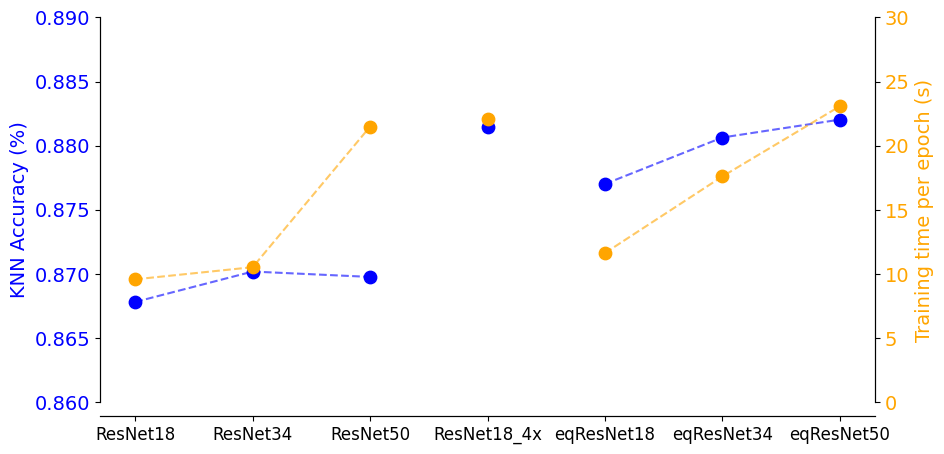

In [21]:
labels = list(resnets_eval.keys())
knn_values = list(resnets_eval.values())

x = np.arange(len(labels))  # numeric positions

fig, ax = plt.subplots(figsize=(10, 5))
size = 14

# scatter points
ax.scatter(x, knn_values, s=80, zorder=3, color='blue', label='KNN Accuracy')
ax.plot(x[:3], knn_values[:3], linestyle='--', alpha=0.6, zorder=2, color='blue')
ax.plot(x[4:], knn_values[4:], linestyle='--', alpha=0.6, zorder=2, color='blue')

ax.set_xticks(x)
ax.set_xticklabels(labels, ha='center', fontsize=size)
ax.tick_params(axis='x', labelsize=size-2)

# baseline_label = 'ResNet18'
# split_x = labels.index(baseline_label) + 0.5
# ax.axvline(split_x, linestyle='--', linewidth=0.75, alpha=0.75, color='black', zorder=1)

ax.set_ylabel('KNN Accuracy (%)', color='blue', fontsize=size)
ax.tick_params(axis='y', labelcolor='blue', labelsize=size)
ax.set_ylim(0.86, 0.89)

# time axis
ax2 = ax.twinx()
time_values = [resnets_time[label] for label in labels]
ax2.scatter(x, time_values, color='orange', marker='o', label='Training time per epoch', zorder=3, s=80, clip_on=False)
ax2.plot(x[:3], time_values[:3], linestyle='--', color='orange', alpha=0.6, zorder=2)
ax2.plot(x[4:], time_values[4:], linestyle='--', color='orange', alpha=0.6, zorder=2)
ax2.set_ylabel('Training time per epoch (s)', color='orange', fontsize=size)
ax2.tick_params(axis='y', labelcolor='orange', labelsize=size)
ax2.set_ylim(0, 30)

ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
# ax2.set_xticklabels(labels, ha='center', fontsize=size)

ax.spines['bottom'].set_position(('outward', 10))
ax2.spines['bottom'].set_position(('outward', 10))

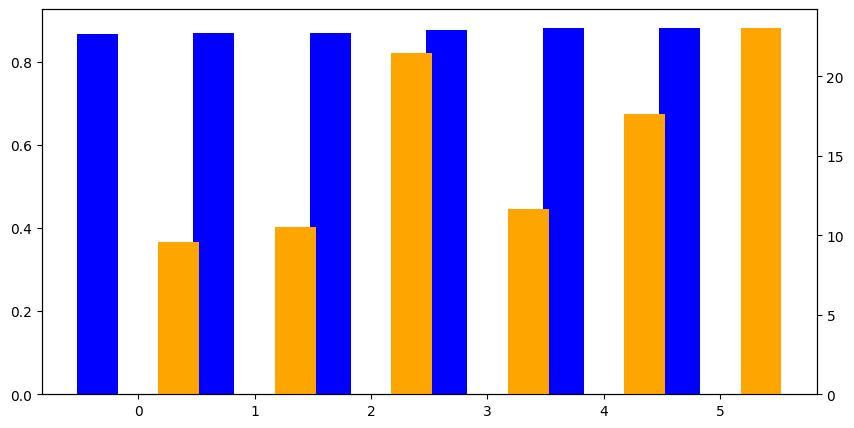

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
ax2 = ax.twinx()

labels = list(resnets_eval.keys())
width = 0.35

for i, label in enumerate(labels):
    knn = resnets_eval[label]
    time = resnets_time[label]

    ax.bar(i - width, knn, width, color='blue')
    ax2.bar(i + width, time, width, color='orange')
    

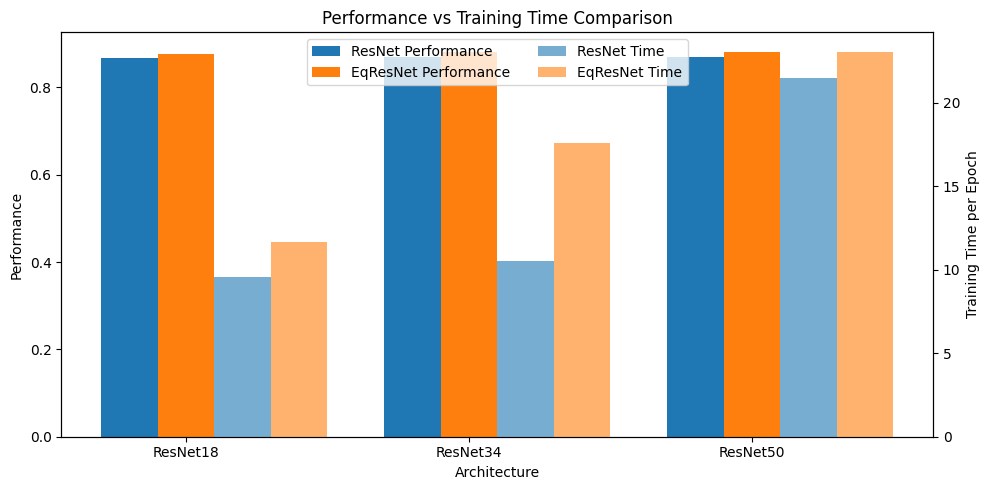

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# ----- Prepare data -----
architectures = ['18', '34', '50']

performance_default = [
    resnets_eval['ResNet18'],
    resnets_eval['ResNet34'],
    resnets_eval['ResNet50']
]

performance_eq = [
    resnets_eval['eqResNet18'],
    resnets_eval['eqResNet34'],
    resnets_eval['eqResNet50']
]

time_default = [
    resnets_time['ResNet18'],
    resnets_time['ResNet34'],
    resnets_time['ResNet50']
]

time_eq = [
    resnets_time['eqResNet18'],
    resnets_time['eqResNet34'],
    resnets_time['eqResNet50']
]

x = np.arange(len(architectures))
width = 0.2

# ----- Plot -----
fig, ax1 = plt.subplots(figsize=(10, 5))

# First y-axis: performance
b1 = ax1.bar(x - width, performance_default, width, label='ResNet Performance')
b2 = ax1.bar(x, performance_eq, width, label='EqResNet Performance')

ax1.set_xlabel('Architecture')
ax1.set_ylabel('Performance')
ax1.set_xticks(x)
ax1.set_xticklabels([f'ResNet{a}' for a in architectures])
ax1.legend(loc='upper left')

# Second y-axis: training time
ax2 = ax1.twinx()

b3 = ax2.bar(x + width, time_default, width, alpha=0.6, label='ResNet Time')
b4 = ax2.bar(x + 2*width, time_eq, width, alpha=0.6, label='EqResNet Time')

ax2.set_ylabel('Training Time per Epoch')

# Combine legends from both axes
bars = [b1, b2, b3, b4]
labels = [bar.get_label() for bar in bars]
ax1.legend(bars, labels, loc='upper center', ncol=2)

plt.title('Performance vs Training Time Comparison')
plt.tight_layout()
plt.show()


# Training progress

In [18]:
list(details_eqresnet_n1a['KNN during training'])


[4, 9, 14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 79, 84, 89, 94, 99]

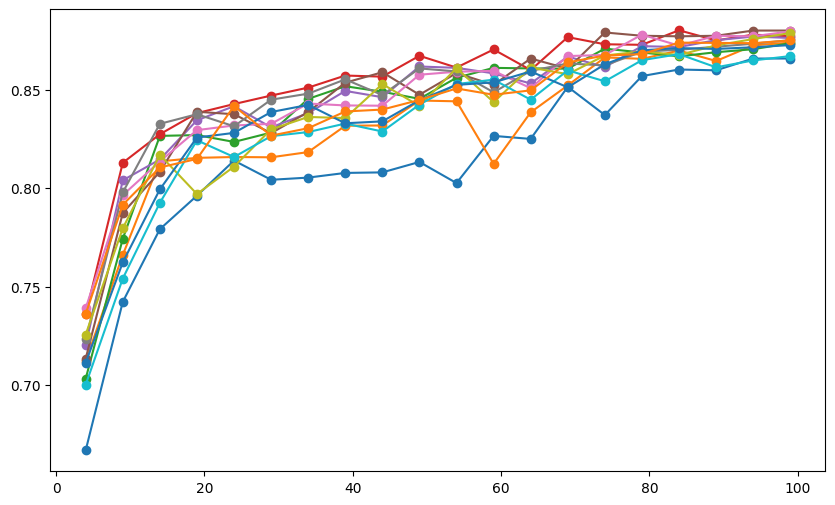

In [10]:
knn_train = {'eqResnet18 (N=1)': (list(details_eqresnet_n1a['KNN during training']), list(details_eqresnet_n1a['KNN during training'].values())),
            'eqResnet18 (N=2)': (list(details_eqresnet_n2a['KNN during training']), list(details_eqresnet_n2a['KNN during training'].values())),
            'eqResnet18 (N=3)': (list(details_eqresnet_n3a['KNN during training']), list(details_eqresnet_n3a['KNN during training'].values())),
            'eqResnet18 (N=4)': (list(details_eqresnet_n4a['KNN during training']), list(details_eqresnet_n4a['KNN during training'].values())),
            'eqResnet18 (N=5)': (list(details_eqresnet_n5a['KNN during training']), list(details_eqresnet_n5a['KNN during training'].values())),
            'eqResnet18 (N=6)': (list(details_eqresnet_n6a['KNN during training']), list(details_eqresnet_n6a['KNN during training'].values())),
            'eqResnet18 (N=7)': (list(details_eqresnet_n7a['KNN during training']), list(details_eqresnet_n7a['KNN during training'].values())),
            'eqResnet18 (N=8)': (list(details_eqresnet_n8a['KNN during training']), list(details_eqresnet_n8a['KNN during training'].values())),
            'eqResnet18 (N=9)': (list(details_eqresnet_n9a['KNN during training']), list(details_eqresnet_n9a['KNN during training'].values())),
            'eqResnet18 (N=10)': (list(details_eqresnet_n10a['KNN during training']), list(details_eqresnet_n10a['KNN during training'].values())),
            'eqResnet18 (N=11)': (list(details_eqresnet_n11a['KNN during training']), list(details_eqresnet_n11a['KNN during training'].values())),
            'eqResnet18 (N=12)': (list(details_eqresnet_n12a['KNN during training']), list(details_eqresnet_n12a['KNN during training'].values()))
            }

# 'Resnet18': (list(details_resnet18['KNN during training']), list(details_resnet18['KNN during training'].values())),

fig, ax = plt.subplots(figsize=(10, 6))
size = 14

for model in knn_train:
    epochs = knn_train[model][0]
    knn_values = knn_train[model][1]
    ax.plot(epochs, knn_values, marker='o', label=model)


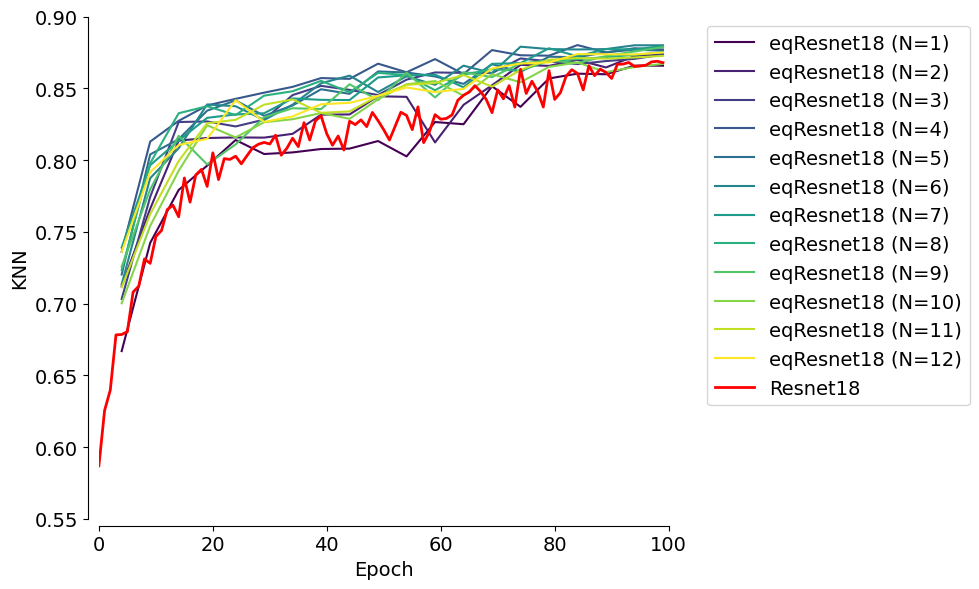

In [37]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))
size=14

# Number of curves
n_curves = len(knn_train)

# Colormap (e.g. viridis goes from light to dark nicely)
cmap = cm.viridis
colors = cmap(np.linspace(0, 1, n_curves))

for (color, (label, (x, y))) in zip(colors, knn_train.items()):
    ax.plot(x, y, label=label, color=color)

ax.plot(list(details_resnet18['KNN during training']), list(details_resnet18['KNN during training'].values()), label='Resnet18', color='red', linewidth=2)

ax.set_xlabel("Epoch", fontsize=size)
ax.set_ylabel("KNN", fontsize=size)
ax.set_ylim(0.55, 0.9)
ax.set_xlim(0, 100)
ax.tick_params(axis='both', labelsize=size)

ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=size)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_position(('outward', 8))


plt.tight_layout()
plt.show()


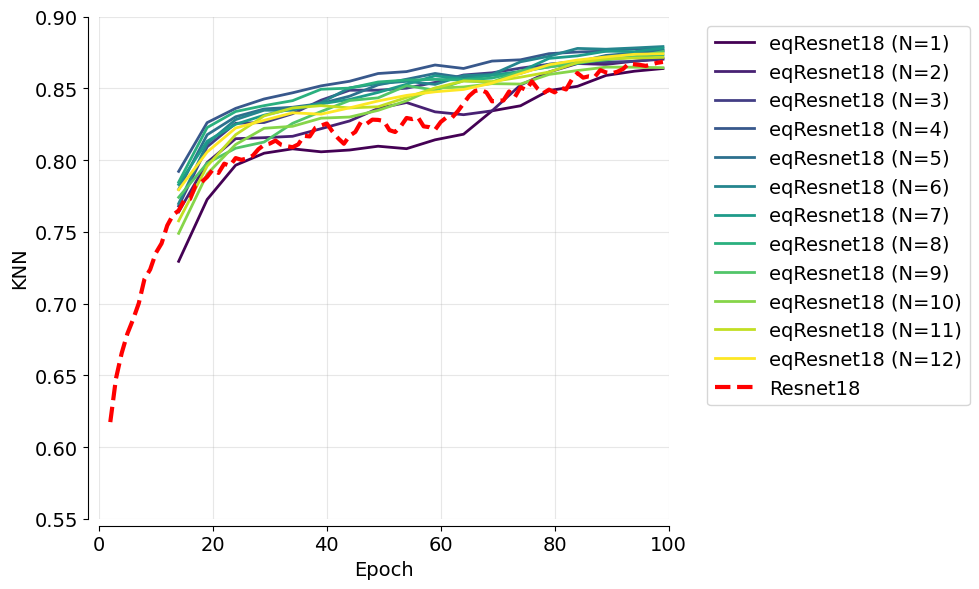

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import re

# -----------------------------
# Moving average function
# -----------------------------
def moving_average(y, window=3):
    y = np.array(y)
    return np.convolve(y, np.ones(window) / window, mode="valid")


# -----------------------------
# Prepare figure and colormap
# -----------------------------
fig, ax = plt.subplots(figsize=(10, 6))

# Extract N values from labels
Ns = []
for label in knn_train.keys():
    N = int(re.search(r"N=(\d+)", label).group(1))
    Ns.append(N)
Ns = np.array(Ns)

# Normalize N for colormap
norm = plt.Normalize(Ns.min(), Ns.max())
cmap = cm.viridis

# -----------------------------
# Plot each curve with moving average
# -----------------------------
window = 3  # smoothing window (number of logged points)

for label, (x, y) in knn_train.items():
    x = np.array(x)
    y = np.array(y)

    # Sort by x just in case
    order = np.argsort(x)
    x = x[order]
    y = y[order]

    # Smooth y
    y_smooth = moving_average(y, window=window)
    # Align x with shortened y
    x_smooth = x[len(x) - len(y_smooth):]

    # Color by N
    N = int(re.search(r"N=(\d+)", label).group(1))
    color = cmap(norm(N))

    # Plot smoothed curve
    ax.plot(x_smooth, y_smooth, color=color, linewidth=2, label=label)

x = list(details_resnet18['KNN during training'])
y = list(details_resnet18['KNN during training'].values())
y_smooth = moving_average(y, window=window)
x_smooth = x[len(x) - len(y_smooth):]
ax.plot(x_smooth, y_smooth, color='red', linewidth=3, label='Resnet18', linestyle='--' )
# -----------------------------
# Labels, legend, layout
# -----------------------------
ax.set_xlabel("Epoch", fontsize=size)
ax.set_ylabel("KNN", fontsize=size)
ax.set_ylim(0.55, 0.9)
ax.set_xlim(0, 100)
ax.tick_params(axis='both', labelsize=size)

ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=size)
ax.grid(True, alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_position(('outward', 8))

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import plotly.graph_objects as go
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import re

# -----------------------------
# Moving average function
# -----------------------------
def moving_average(y, window=3):
    y = np.array(y)
    return np.convolve(y, np.ones(window) / window, mode="valid")

# -----------------------------
# Prepare colormap
# -----------------------------
# Extract N values from labels
Ns = []
for label in knn_train.keys():
    N = int(re.search(r"N=(\d+)", label).group(1))
    Ns.append(N)
Ns = np.array(Ns)

# Normalize N for colormap
norm = mcolors.Normalize(vmin=Ns.min(), vmax=Ns.max())
cmap = cm.viridis

# -----------------------------
# Create Plotly figure
# -----------------------------
fig = go.Figure()

window = 3  # smoothing window

for label, (x, y) in knn_train.items():
    x = np.array(x)
    y = np.array(y)

    # Sort by x just in case
    order = np.argsort(x)
    x = x[order]
    y = y[order]

    # Smooth y
    y_smooth = moving_average(y, window=window)
    x_smooth = x[len(x) - len(y_smooth):]

    # Color by N
    N = int(re.search(r"N=(\d+)", label).group(1))
    rgba = cmap(norm(N))  # returns RGBA tuple
    color = f"rgba({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)}, {rgba[3]})"

    # Add trace to figure
    fig.add_trace(
        go.Scatter(
            x=x_smooth,
            y=y_smooth,
            mode='lines',
            name=label,
            line=dict(color=color, width=2),
            hovertemplate=f"{label}<br>Epoch: %{{x}}<br>Accuracy: %{{y:.3f}}<extra></extra>"
        )
    )

# Add ResNet18 curve
x = list(details_resnet18['KNN during training'])
y = list(details_resnet18['KNN during training'].values())
y_smooth = moving_average(y, window=window)
x_smooth = x[len(x) - len(y_smooth):]
fig.add_trace(
    go.Scatter(
        x=x_smooth,
        y=y_smooth,
        mode='lines',
        name='ResNet18',
        line=dict(color='red', width=3),
        hovertemplate="ResNet18<br>Epoch: %{x}<br>Accuracy: %{y:.3f}<extra></extra>"
    )
)

# -----------------------------
# Layout
# -----------------------------
fig.update_layout(
    title="kNN during training (smoothed, moving average)",
    xaxis_title="Epoch",
    yaxis_title="kNN accuracy",
    hovermode="closest",
    width=800,
    height=600
)

fig.show()


In [41]:
import numpy as np
import plotly.graph_objects as go
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import re

# -----------------------------
# Moving average function
# -----------------------------
def moving_average(y, window=3):
    y = np.array(y)
    return np.convolve(y, np.ones(window) / window, mode="valid")

# -----------------------------
# Prepare colormap
# -----------------------------
# Extract N values from labels
Ns = []
for label in knn_train.keys():
    N = int(re.search(r"N=(\d+)", label).group(1))
    Ns.append(N)
Ns = np.array(Ns)

# Normalize N for colormap
norm = mcolors.Normalize(vmin=Ns.min(), vmax=Ns.max())
cmap = cm.viridis

# -----------------------------
# Create Plotly figure
# -----------------------------
fig = go.Figure()

window = 3  # smoothing window

for label, (x, y) in knn_train.items():
    x = np.array(x)
    y = np.array(y)


    # Color by N
    N = int(re.search(r"N=(\d+)", label).group(1))
    rgba = cmap(norm(N))  # returns RGBA tuple
    color = f"rgba({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)}, {rgba[3]})"

    # Add trace to figure
    fig.add_trace(
        go.Scatter(
            x=x,
            y=y,
            mode='lines',
            name=label,
            line=dict(color=color, width=2),
            hovertemplate=f"{label}<br>Epoch: %{{x}}<br>Accuracy: %{{y:.3f}}<extra></extra>"
        )
    )

# Add ResNet18 curve
x = list(details_resnet18['KNN during training'])
y = list(details_resnet18['KNN during training'].values())

fig.add_trace(
    go.Scatter(
        x=x,
        y=y,
        mode='lines',
        name='ResNet18',
        line=dict(color='red', width=3),
        hovertemplate="ResNet18<br>Epoch: %{x}<br>Accuracy: %{y:.3f}<extra></extra>"
    )
)

# -----------------------------
# Layout
# -----------------------------
fig.update_layout(
    title="kNN during training (smoothed, moving average)",
    xaxis_title="Epoch",
    yaxis_title="kNN accuracy",
    hovermode="closest",
    width=800,
    height=600
)

fig.show()
